In [5]:
import os
import numpy as np
import pandas as pd
import configparser
import matplotlib.pyplot as plt

config = configparser.ConfigParser()
config.read('CR10X_Varriable_Deffs.ini')

DataPath = config['DATA']['path']
subDirs = [x[0] for x in os.walk(DataPath)]
subDirs.remove(DataPath)

Sites = config['DATA']['Sites'].split(',')

# Get the header info from the .FSL file
def parse_FSL(file):
    Metadata = open(file)
    array_id = None
    TableDef = {}
    TableDef['AGG']=[]
    for line in Metadata.readlines():
        if line == '\n':
            array_id = None
        # Defines tables by array
        elif 'Output_Table' in line:
            array_id = int(line.split(' ')[0])
            TableDef[array_id]= []
        # Defines values for each array
        elif array_id is not None:
            rec = line.split(' ')[1]
            TableDef[array_id].append(rec)
            # Gets aggregation statistics (AGG)
            sp = rec.split('_')
            if len(sp)>1 and sp[-1] !='RTM' and sp[-1] not in TableDef['AGG']:

                TableDef['AGG'].append(sp[-1])
            
    return(TableDef)

def makeDateTime(df,year,doy,hrmn):
    df.loc[df[hrmn]==2400,hrmn]=0
    df['datetime'] = pd.to_datetime(
                df[year].astype(str) +'-' +
                df[doy].astype(str).str.zfill(3)+' '+
                df[hrmn].astype(str).str.zfill(4).str[:2]+':'+
                df[hrmn].astype(str).str.zfill(4).str[2:],
                format='%Y-%j %H:%M')
    df = df.set_index(pd.DatetimeIndex(df['datetime']))#,inplace=True,drop=True)
    df=df.drop([year,doy,hrmn,'datetime'],axis=1)
    return(df)

# Loop through sites, merge files to one .csv and rename headers
AllData = pd.DataFrame()
for site in Sites:
    DailyData = pd.DataFrame()
    HalfHourlyData = pd.DataFrame()
    TableDef = parse_FSL(config[site]['FSL'])
    for dir in subDirs:
        file = config['DATA']['FileName'].replace('{LOGGER}',site)
        data = pd.read_csv(f'{dir}/{file}',header=None,na_values=[-6999])
        # Half-hourly data
        HH_id = int(config[site]['30_Min'])
        HH = data.loc[data[0]==HH_id]
        for c in HH.columns:
            HH = HH.rename(columns={c:TableDef[HH_id][c].upper()})
        cols = [c for c in HH.columns]
        # Pattern match variables we want to rename
        for k in config[site].keys():
            k = k.upper()
            for stat in TableDef['AGG']:
                val = k.replace('AGG',stat)
                if val in cols:
                    name = config[site][k].replace('AGG',stat).replace('POS',site)
                    HH = HH.rename(columns={val:name})
        HH = HH.drop([str(HH_id)],axis=1)
        HH = makeDateTime(HH,'YEAR_RTM','DAY_RTM','HOUR_MINUTE_RTM')
        HH = HH.resample('30T').first()
        HH = HH.loc[HH.index.isin(HalfHourlyData.index)==False]
        HalfHourlyData = pd.concat([HalfHourlyData,HH])

        # Daily data
        DY_id = int(config[site]['Daily'])
        DY = data.loc[data[0]==DY_id]
        for c in DY.columns:
            try:
                DY = DY.rename(columns={c:TableDef[DY_id][c].upper()})
            except:
                DY = DY.drop(c,axis=1)
        cols = [c.upper() for c in DY.columns]
        # Pattern match variables we want to rename
        for k in config[site].keys():
            k = k.upper()
            for stat in TableDef['AGG']:
                val = k.replace('AGG',stat)
                if val in cols:
                    name = config[site][k].replace('AGG',stat).replace('POS',site)
                    DY = DY.rename(columns={val:name})
        DY = DY.drop([str(DY_id)],axis=1)
        DY = makeDateTime(DY,'YEAR_RTM','DAY_RTM','HOUR_MINUTE_RTM')
        DY = DY.resample('D').first()
        DY = DY.loc[DY.index.isin(DailyData.index)==False]
        DailyData = pd.concat([DailyData,DY])
    
    HalfHourlyData = HalfHourlyData.join(DailyData)
    
    AllData = pd.concat([AllData,HalfHourlyData],axis=1)

for i,d in enumerate(config['DATA']['SERVICE_DATES'].split(',')):
    d = pd.to_datetime(d).date()
    if i == 0:
        AllData=AllData.loc[AllData.index.date > d]
    else:
        AllData.loc[AllData.index.date == d] = np.nan
AllData.head()

,PannelTemp_PSLS_AVG,TS_PSLS_S_5_AVG,TS_PSLS_S_10_AVG,TS_PSLS_S_30_AVG,TS_PSLS_R_5_AVG,TS_PSLS_R_10_AVG,TS_PSLS_R_30_AVG,Voltage_PSLS_MIN,PROGSIG_PSLS_AVG,PannelTemp_PSTS_AVG,...,Voltage_PSW_S_MIN,PROGSIG_PSW_S_AVG,PannelTemp_PSW_R_AVG,TS_PSW_R_5_AVG,TS_PSW_R_10_AVG,TS_PSW_R_30_AVG,VWC_PSW_R_AVG,PAUS_PSW_R_AVG,Voltage_PSW_R_MIN,PROGSIG_PSW_R_AVG
datetime,,,,,,,,,,,,,,,,,,,,,
2023-03-19 00:00:00,8.190,5.828,2.450,5.525,7.040,5.980,4.022,12.58,1898.0,7.560,...,12.34,196.1,7.170,6.171,5.403,4.938,0.847,40.90,12.55,3817.0
2023-03-19 00:30:00,1.173,5.359,2.137,6.010,6.422,6.413,4.531,NaN,NaN,0.948,...,NaN,NaN,-0.067,5.195,5.548,5.221,0.849,40.94,NaN,NaN
2023-03-19 01:00:00,0.814,5.405,1.997,6.014,6.159,6.380,4.548,NaN,NaN,0.578,...,NaN,NaN,-0.355,5.100,5.535,5.231,0.849,40.94,NaN,NaN
2023-03-19 01:30:00,0.516,5.296,2.074,5.964,5.932,6.277,4.481,NaN,NaN,0.261,...,NaN,NaN,-0.609,4.966,5.486,5.206,0.849,40.94,NaN,NaN
2023-03-19 02:00:00,0.274,5.333,1.863,5.881,5.824,6.335,4.249,NaN,NaN,-0.001,...,NaN,NaN,-0.803,4.836,5.439,5.189,0.849,40.94,NaN,NaN


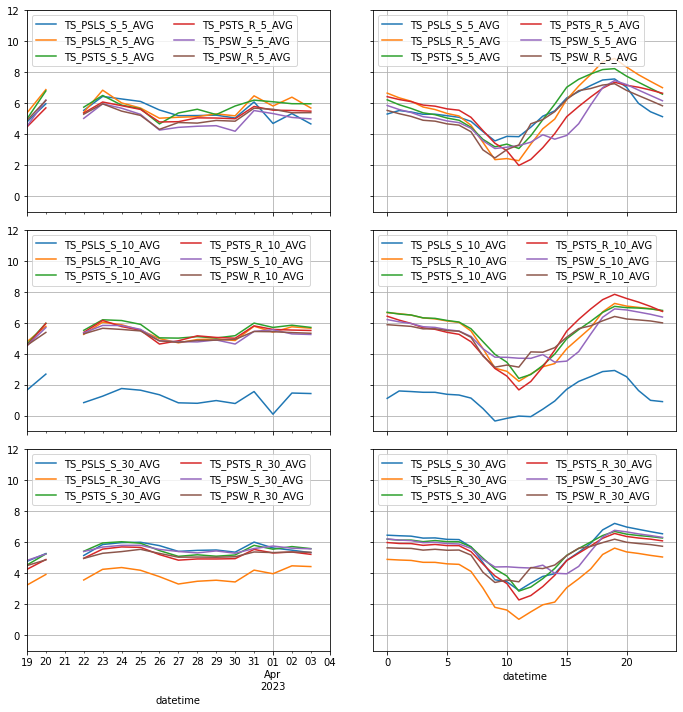

In [17]:
Positions = ['PSLS_S','PSLS_R','PSTS_S','PSTS_R','PSW_S','PSW_R']


fig,ax=plt.subplots(3,2,figsize=(10,10),sharey=True,sharex='col')

depths = ['5','10','30']

ax[0,0].set_ylim(-1,12)
for i,depth in enumerate(depths):
    cols = [f'TS_{pos}_{depth}_AVG' for pos in Positions]
    AllData[cols].resample('D').mean().plot(ax=ax[i,0])
    ax[i,0].legend(ncol=2,loc=2)
    ax[i,0].grid()
    AllData[cols].groupby(AllData.index.hour).mean().plot(ax=ax[i,1])
    ax[i,1].legend(ncol=2,loc=2)
    ax[i,1].grid()
plt.tight_layout()

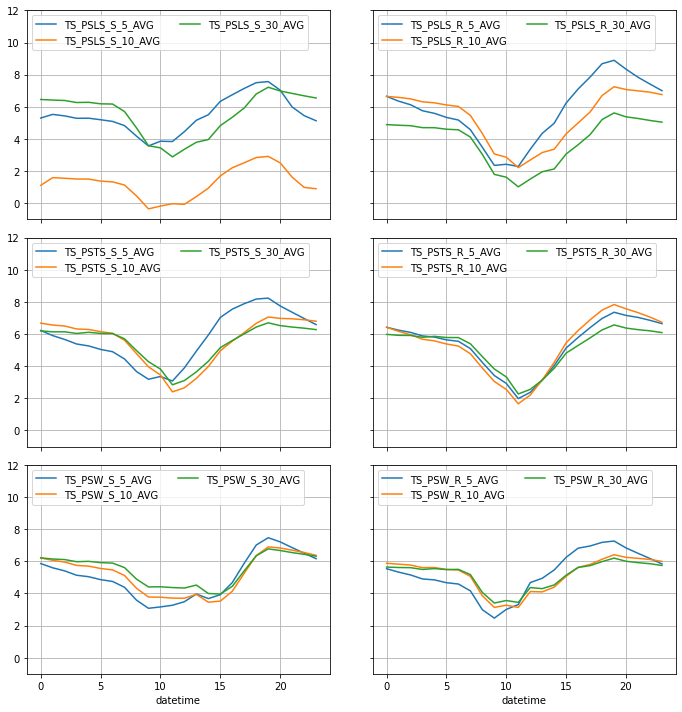

In [16]:
Positions = ['PSLS','PSTS','PSW']


fig,ax=plt.subplots(3,2,figsize=(10,10),sharey=True,sharex='col')

depths = ['5','10','30']

ax[0,0].set_ylim(-1,12)
for i,pos in enumerate(Positions):
    cols = [f'TS_{pos}_S_{depth}_AVG' for depth in depths]
    AllData[cols].groupby(AllData.index.hour).mean().plot(ax=ax[i,0])
    ax[i,0].legend(ncol=2,loc=2)
    ax[i,0].grid()
    cols = [f'TS_{pos}_R_{depth}_AVG' for depth in depths]
    AllData[cols].groupby(AllData.index.hour).mean().plot(ax=ax[i,1])
    ax[i,1].legend(ncol=2,loc=2)
    ax[i,1].grid()
plt.tight_layout()